### MLND Capstone Project

This is the notebook for data analysis and modeling for the MLND Capstone : Predicting Home Loan Default, based on the Kaggle competition Home Credit [here](https://www.kaggle.com/c/home-credit-default-risk).

First lets import the relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

Importing the data set.  Here we only use the main table application_train

In [2]:
train = pd.read_csv("data/application_train.csv")
train = train.drop(columns=["SK_ID_CURR"])
df = train.copy()

### Basic EDA

In [3]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.shape

(307511, 121)

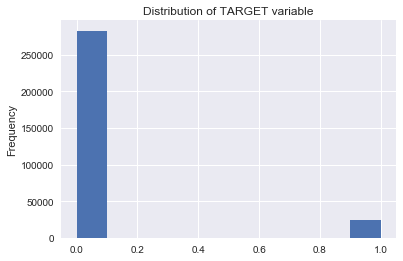

In [5]:
train["TARGET"].plot.hist(title="Distribution of TARGET variable")

In [6]:
train.drop(["TARGET"],axis=1).dtypes.value_counts()

float64    65
int64      39
object     16
dtype: int64

Lets look at the missing values for float variables

In [12]:
train_types = train.dtypes
list_float_var = train_types[train_types==np.float].index
train_float = train[list_float_var]
null_perc = train_float.isnull().sum() / len(train_float)
print("Num of columns with >50% missing data :", len(null_perc[null_perc>0.5]))
print("Num of columns with >60% missing data :", len(null_perc[null_perc>0.6]))

Num of columns with >50% missing data : 38
Num of columns with >60% missing data : 16


How are the numbers actually distributed?

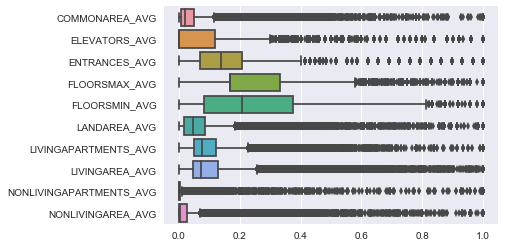

In [16]:
sns.boxplot(data = train[list_float_var[15:25]], orient="h")

Many of them range between 0 and 1

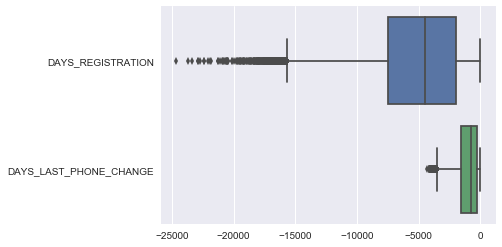

In [17]:
sns.boxplot(data = train[list_float_var[[5,58]]], orient="h")

while some numbers are just negative

Lets turn to the integer variables, and see how many unique values are there for each of the feature

In [19]:
list_int_var = train_types[train_types==np.int].index
train_int = train[list_int_var]
train_int.nunique()

TARGET                             2
CNT_CHILDREN                      15
DAYS_BIRTH                     17460
DAYS_EMPLOYED                  12574
DAYS_ID_PUBLISH                 6168
FLAG_MOBIL                         2
FLAG_EMP_PHONE                     2
FLAG_WORK_PHONE                    2
FLAG_CONT_MOBILE                   2
FLAG_PHONE                         2
FLAG_EMAIL                         2
REGION_RATING_CLIENT               3
REGION_RATING_CLIENT_W_CITY        3
HOUR_APPR_PROCESS_START           24
REG_REGION_NOT_LIVE_REGION         2
REG_REGION_NOT_WORK_REGION         2
LIVE_REGION_NOT_WORK_REGION        2
REG_CITY_NOT_LIVE_CITY             2
REG_CITY_NOT_WORK_CITY             2
LIVE_CITY_NOT_WORK_CITY            2
FLAG_DOCUMENT_2                    2
FLAG_DOCUMENT_3                    2
FLAG_DOCUMENT_4                    2
FLAG_DOCUMENT_5                    2
FLAG_DOCUMENT_6                    2
FLAG_DOCUMENT_7                    2
FLAG_DOCUMENT_8                    2
F

In fact most of them are flag variables which should be treated as categorical

Finally lets look at the object variables, and see how much missing data do we have

In [23]:
list_obj_var = train_types[train_types==np.object].index
train_obj = train[list_obj_var]
train_obj.isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

A few of them have missing data which we simply just set to a constant

### Data Preprocessing

We will need to first create a few helper functions to facilitate data preprocessing

The create_dummy function performs one hot encoding

In [26]:
def create_dummy(df, col_list):
    '''
    parameters : df - input dataframe, col_list - list of columns to be one-hot-encoded
    returns : new df with those fields in col_list one-hot-encoded
    '''
    res = df.copy()
    for col in col_list:
        df[col] = df[col].apply(lambda s:col+"_"+str(s))
        dummy = pd.get_dummies(df[col])
        res = pd.concat([res, dummy], axis=1)
        res = res.drop(columns = [col])
    return res

The encode_data function selects which columns to be one hot encoded and returns data frame which is one hot encoded

In [28]:
def encode_data(org_df):
    
    df = org_df.copy()
    df_types = df.dtypes
    list_obj_var = df_types[df_types==np.object].index.tolist()
    list_int_var = df_types[df_types==np.integer].index.tolist()
    list_cat_var = [ele for ele in list_int_var if ele not in ("TARGET","CNT_CHILDREN","DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH","HOUR_APPR_PROCESS_START")]
    list_cat_var = list_cat_var + list_obj_var
    df = create_dummy(df, list_cat_var)
    
    return df

The normalize_data function scales the float variables

In [29]:
def normalize_data(org_df):
    '''
    parameter : org_df - dataframe
    returns : a new dataframe where all float variables are normalize
    '''
    df = org_df.copy()
    scaler = StandardScaler()
    df_types = df.dtypes
    list_float_var = df_types[df_types==np.float].index
    df[list_float_var] = scaler.fit_transform(df[list_float_var])
    
    return df

The split_res_data function split the dataset into training and validation set.  Furthermore, it oversample the training data using SMOTE

In [31]:
def split_res_data(X, y):    
    '''
    parameters: df, dataframe consisting of all training data
    returns : X_train, y_train, X_test, y_test
    ''' 
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    
    
    # oversampling with SMOTE
    sm = SMOTE(random_state=12)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    X_train = pd.DataFrame(X_train_res)
    X_train.columns = X_test.columns
    y_train = pd.DataFrame(y_train_res)
    y_train.columns = y_test.columns
    
    return X_train, y_train, X_test, y_test

Finally we are now ready to impute, encode, normalize, resample the data and prepare the training dataset and validation dataset

In [36]:
df = df.fillna(value=0)
df = encode_data(df)
df = normalize_data(df)

y = df[["TARGET"]]
X = df.drop(columns = ["TARGET"])

X_train, y_train, X_test, y_test = split_res_data(X,y)

### Model Training

We shall train on three models - Random Forest, XGBoost, and LightGBM - using the default settings

In [48]:
def train_score(clf):
    clf.fit(X_train, y_train)
    pred_test = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, pred_test[:,1])
    return score

clfs = {"rf":RandomForestClassifier(), "xgb":XGBClassifier(), "lgb":LGBMClassifier()}

for name, clf in clfs.items():
    print(name, train_score(clf))

rf 0.6040189512601487
xgb 0.7303743963457479
lgb 0.7548613917095266


The validation scores indicate LightGBM has a better edge in terms of AUC_ROC score

### Hyper Parameter Tuning

We use LightGBM as our model and do a grid search across the parameter space

In [101]:
best_score = 0
for num_leaves in [15,63,255]:
    for min_data_in_leaves in [10, 100, 1000]:
        for max_depth in [-1, 5, 10]:
            clf = LGBMClassifier(num_leaves=num_leaves, min_data_in_leaves=min_data_in_leaves, max_depth=max_depth)
            clf.fit(X_train,y_train)
            pred_test = clf.predict_proba(X_test)
            score = roc_auc_score(y_test, pred_test[:,1])
            print(num_leaves,min_data_in_leaves,max_depth,score)
            if score > best_score:
                best_score = score
                params = [num_leaves, min_data_in_leaves, max_depth]

15 10 -1 0.7504735658727387
15 10 5 0.745774483609593
15 10 10 0.7497892266592822
15 100 -1 0.7504735658727387
15 100 5 0.745774483609593
15 100 10 0.7497892266592822
15 1000 -1 0.7504735658727387
15 1000 5 0.745774483609593
15 1000 10 0.7497892266592822
63 10 -1 0.7550540780314551
63 10 5 0.7470358741378231
63 10 10 0.7547367582711004
63 100 -1 0.7550540780314551
63 100 5 0.7470358741378231
63 100 10 0.7547367582711004
63 1000 -1 0.7550540780314551
63 1000 5 0.7470358741378231
63 1000 10 0.7547367582711004
255 10 -1 0.7516014125391306
255 10 5 0.7470358741378231
255 10 10 0.7508929150511032
255 100 -1 0.7516014125391306
255 100 5 0.7470358741378231
255 100 10 0.7508929150511032
255 1000 -1 0.7516014125391306
255 1000 5 0.7470358741378231
255 1000 10 0.7508929150511032


Based on the above (rather limited) search, we see that a better set of hyperparameters would be
- num_leaves : 63
- min_data_in_leaves : 10
- max_depth : -1 (unlimited)

### Learning Curve

We finally evaluate the model using learning curve by sampling the training data according to various sizes and evaluate the AUC_ROC score for training and validation sets

In [102]:
ratios = np.linspace(0.1,0.9,8)
clf = LGBMClassifier(num_leaves=63, min_data_in_leaves=10)
train_score = []
test_score = []
for ratio in ratios:
    X, _, y , _ = train_test_split(X_train,y_train,test_size=1.-ratio)
    clf.fit(X,y)
    pred_train = clf.predict_proba(X)
    train_score.append(roc_auc_score(y, pred_train[:,1]))
    pred_test = clf.predict_proba(X_test)
    test_score.append(roc_auc_score(y_test, pred_test[:,1]))  

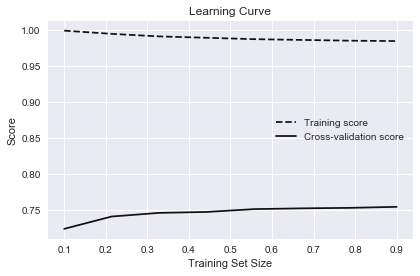

In [103]:
plt.plot(ratios, train_score, '--', color="#111111",  label="Training score")
plt.plot(ratios, test_score, color="#111111", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

As shown above, model has high trainig score but low validation score.  This could point to potential overfitting

### Model Intepretation

To have an attempt in understanding what the model is telling us, we take a look at the feature importances based on the model output

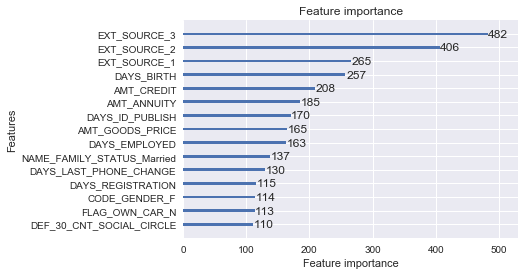

In [127]:
fea_imp = pd.DataFrame()
fea_imp["features"] = list(X_train)
fea_imp["importance"] = clf.feature_importances_
from lightgbm import plot_importance
plot_importance(clf, max_num_features=15)
plt.show()

Based on the top 15 features, we see that EXT_SOURCES, DAYS_BIRTH, AMT_CREDIT, AMT_ANNUITY etc are predictors for the probability of default.  These variables are related to financial status of an applicant so we can be rather confident with the model predictions